## Hypothesis: In T20 Cricket Match Good Players does not make Good Team Instead Power Hitters with not so consistent Performace are better for the Team. Power Hitters Wins over Consistency !!

<br />
<center>
<img src="data/images/ipl-logo.png" width=600 />
</center>

In [1]:
import numpy as np
import pandas as pd
import scipy as scipy
from sklearn.model_selection import train_test_split
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
import pymc3 as pm, theano.tensor as tt
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
%matplotlib inline
# Linear Regression to verify implementation
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('data/Match.csv')
df.head()

,Match_SK,match_id,Team1,Team2,match_date,Season_Year,Venue_Name,City_Name,Country_Name,Toss_Winner,match_winner,Toss_Name,Win_Type,Outcome_Type,ManOfMach,Win_Margin,Country_id
0,0,335987,Royal Challengers Bangalore,Kolkata Knight Riders,4/18/2008,2008,M Chinnaswamy Stadium,Bangalore,India,Royal Challengers Bangalore,Kolkata Knight Riders,field,runs,Result,BB McCullum,140.0,1
1,1,335988,Kings XI Punjab,Chennai Super Kings,4/19/2008,2008,"Punjab Cricket Association Stadium, Mohali",Chandigarh,India,Chennai Super Kings,Chennai Super Kings,bat,runs,Result,MEK Hussey,33.0,1
2,2,335989,Delhi Daredevils,Rajasthan Royals,4/19/2008,2008,Feroz Shah Kotla,Delhi,India,Rajasthan Royals,Delhi Daredevils,bat,wickets,Result,MF Maharoof,9.0,1
3,3,335990,Mumbai Indians,Royal Challengers Bangalore,4/20/2008,2008,Wankhede Stadium,Mumbai,India,Mumbai Indians,Royal Challengers Bangalore,bat,wickets,Result,MV Boucher,5.0,1
4,4,335991,Kolkata Knight Riders,Deccan Chargers,4/20/2008,2008,Eden Gardens,Kolkata,India,Deccan Chargers,Kolkata Knight Riders,bat,wickets,Result,DJ Hussey,5.0,1


## Why Bayesian ??

Frequentist (or classical) methods assume that unknown parameters are fixed constants. This approach is best suited in order to falsify a hypothesis, but to prove a hypothesis we need a way to re-evaluate the reliability of a statement or degree of confidence for one of the teams winning over other, as the ‘variables’ of our hypothesis (like power hitting or consistency) involved in the game changes.

So we try to find a way of combining prior information with data, within a solid decision theoretical framework. This can be achieved by using prior information about a parameter to form a distribution for future analysis and with the new observations, the previous posterior distribution can be used as a prior. All conclusions logically follow from Bayes’ theorem. Thus our analysis employs a Bayesian framework to find the dependency of strike rate and consistency on team's performance.

While the results of the Date’s analysis reveal the importance of power hitting, below analysis aims to investigate the impact of power hitting, in comparison to improving consistency, their effects on the outcomes of a n-match bilateral series between multiple teams by the use of a Bayesian framework.

In [3]:
df_prior = df[['Team1', 'Team2', 'Win_Margin', 'match_winner', 'Win_Type', 'Season_Year']]
df_prior

,Team1,Team2,Win_Margin,match_winner,Win_Type,Season_Year
0,Royal Challengers Bangalore,Kolkata Knight Riders,140.0,Kolkata Knight Riders,runs,2008
1,Kings XI Punjab,Chennai Super Kings,33.0,Chennai Super Kings,runs,2008
2,Delhi Daredevils,Rajasthan Royals,9.0,Delhi Daredevils,wickets,2008
3,Mumbai Indians,Royal Challengers Bangalore,5.0,Royal Challengers Bangalore,wickets,2008
4,Kolkata Knight Riders,Deccan Chargers,5.0,Kolkata Knight Riders,wickets,2008
...,...,...,...,...,...,...
632,Delhi Daredevils,Royal Challengers Bangalore,10.0,Royal Challengers Bangalore,runs,2017
633,Mumbai Indians,Rising Pune Supergiants,20.0,Rising Pune Supergiants,runs,2017
634,Sunrisers Hyderabad,Kolkata Knight Riders,7.0,Kolkata Knight Riders,wickets,2017
635,Mumbai Indians,Kolkata Knight Riders,6.0,Mumbai Indians,wickets,2017


## Data Cleaning

In [4]:
## Total Teams included in our dataset
teams = df_prior['Team1'].unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['TeamIndex'] = teams.index
teams

,team,TeamIndex
0,Royal Challengers Bangalore,0
1,Kings XI Punjab,1
2,Delhi Daredevils,2
3,Mumbai Indians,3
4,Kolkata Knight Riders,4
5,Rajasthan Royals,5
6,Deccan Chargers,6
7,Chennai Super Kings,7
8,Kochi Tuskers Kerala,8
9,Pune Warriors,9


In [5]:
df_prior['Team1'].unique()

array(['Royal Challengers Bangalore', 'Kings XI Punjab',
       'Delhi Daredevils', 'Mumbai Indians', 'Kolkata Knight Riders',
       'Rajasthan Royals', 'Deccan Chargers', 'Chennai Super Kings',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Sunrisers Hyderabad',
       'Gujarat Lions', 'Rising Pune Supergiants'], dtype=object)

In [ ]:
df_prior = pd.merge(df_prior, teams, left_on='Team1', right_on='team', how='left')
# df_prior = df_prior.rename(columns = {'TeamIndex': 'TeamIndex'}).drop('team', 1)
df_prior

In [7]:
# df_prior = df_prior.iloc[: , :-1]
# df_prior

In [8]:
def func(row):
    if row['Team1'] != row['match_winner'] or row['Win_Type'] == 'wickets':
        return 0
    elif row['Team1'] == row['match_winner']:
        return row['Win_Margin']
    else:
        return 0

df_prior['win_margin_runs_state'] = df_prior.apply(func, axis=1)

df_prior

,Team1,Team2,Win_Margin,match_winner,Win_Type,Season_Year,team,TeamIndex,win_margin_runs_state
0,Royal Challengers Bangalore,Kolkata Knight Riders,140.0,Kolkata Knight Riders,runs,2008,Royal Challengers Bangalore,0,0.0
1,Kings XI Punjab,Chennai Super Kings,33.0,Chennai Super Kings,runs,2008,Kings XI Punjab,1,0.0
2,Delhi Daredevils,Rajasthan Royals,9.0,Delhi Daredevils,wickets,2008,Delhi Daredevils,2,0.0
3,Mumbai Indians,Royal Challengers Bangalore,5.0,Royal Challengers Bangalore,wickets,2008,Mumbai Indians,3,0.0
4,Kolkata Knight Riders,Deccan Chargers,5.0,Kolkata Knight Riders,wickets,2008,Kolkata Knight Riders,4,0.0
...,...,...,...,...,...,...,...,...,...
632,Delhi Daredevils,Royal Challengers Bangalore,10.0,Royal Challengers Bangalore,runs,2017,Delhi Daredevils,2,0.0
633,Mumbai Indians,Rising Pune Supergiants,20.0,Rising Pune Supergiants,runs,2017,Mumbai Indians,3,0.0
634,Sunrisers Hyderabad,Kolkata Knight Riders,7.0,Kolkata Knight Riders,wickets,2017,Sunrisers Hyderabad,10,0.0
635,Mumbai Indians,Kolkata Knight Riders,6.0,Mumbai Indians,wickets,2017,Mumbai Indians,3,0.0


In [9]:
# Converting Wickets to run for home team to make units of runs and wickets as same
def func(row):
    if row['Team1'] == row['match_winner'] and row['Win_Type'] == 'wickets':
        if row['Win_Margin'] == 10:
            return 50 
        elif row['Win_Margin'] == 9:
            return 45 
        elif row['Win_Margin'] == 8:
            return 40
        elif row['Win_Margin'] == 7:
            return 35 
        elif row['Win_Margin'] == 6:
            return 30 
        elif row['Win_Margin'] == 5:
            return 25
        elif row['Win_Margin'] == 4:
            return 20 
        elif row['Win_Margin'] == 3:
            return 15 
        elif row['Win_Margin'] == 2:
            return 10
        elif row['Win_Margin'] == 1:
            return 5  
        else:
            return 0
    elif row['Team1'] != row['match_winner']:
        return 0
    else:
        return 0

df_prior['win_margin_wickets_to_run_state'] = df_prior.apply(func, axis=1)

In [10]:
df_prior

,Team1,Team2,Win_Margin,match_winner,Win_Type,Season_Year,team,TeamIndex,win_margin_runs_state,win_margin_wickets_to_run_state
0,Royal Challengers Bangalore,Kolkata Knight Riders,140.0,Kolkata Knight Riders,runs,2008,Royal Challengers Bangalore,0,0.0,0
1,Kings XI Punjab,Chennai Super Kings,33.0,Chennai Super Kings,runs,2008,Kings XI Punjab,1,0.0,0
2,Delhi Daredevils,Rajasthan Royals,9.0,Delhi Daredevils,wickets,2008,Delhi Daredevils,2,0.0,45
3,Mumbai Indians,Royal Challengers Bangalore,5.0,Royal Challengers Bangalore,wickets,2008,Mumbai Indians,3,0.0,0
4,Kolkata Knight Riders,Deccan Chargers,5.0,Kolkata Knight Riders,wickets,2008,Kolkata Knight Riders,4,0.0,25
...,...,...,...,...,...,...,...,...,...,...
632,Delhi Daredevils,Royal Challengers Bangalore,10.0,Royal Challengers Bangalore,runs,2017,Delhi Daredevils,2,0.0,0
633,Mumbai Indians,Rising Pune Supergiants,20.0,Rising Pune Supergiants,runs,2017,Mumbai Indians,3,0.0,0
634,Sunrisers Hyderabad,Kolkata Knight Riders,7.0,Kolkata Knight Riders,wickets,2017,Sunrisers Hyderabad,10,0.0,0
635,Mumbai Indians,Kolkata Knight Riders,6.0,Mumbai Indians,wickets,2017,Mumbai Indians,3,0.0,30


In [11]:
def func(row):
    if row['Team2'] != row['match_winner'] or row['Win_Type'] == 'wickets':
        return 0
    elif row['Team2'] == row['match_winner']:
        return row['Win_Margin']
    else:
        return 0

df_prior['win_margin_runs_non_state'] = df_prior.apply(func, axis=1)

In [12]:
# Converting Wickets to run for opposite team to make units of runs and wickets as same
def func(row):
    if row['Team2'] == row['match_winner'] and row['Win_Type'] == 'wickets':
        if row['Win_Margin'] == 10:
            return 50 
        elif row['Win_Margin'] == 9:
            return 45 
        elif row['Win_Margin'] == 8:
            return 40
        elif row['Win_Margin'] == 7:
            return 35 
        elif row['Win_Margin'] == 6:
            return 30 
        elif row['Win_Margin'] == 5:
            return 25
        elif row['Win_Margin'] == 4:
            return 20 
        elif row['Win_Margin'] == 3:
            return 15 
        elif row['Win_Margin'] == 2:
            return 10
        elif row['Win_Margin'] == 1:
            return 5
        else:
            return 0
    elif row['Team2'] != row['match_winner']:
        return 0
    else:
        return 0

df_prior['win_margin_wickets_to_run_non_state'] = df_prior.apply(func, axis=1)
df_prior

,Team1,Team2,Win_Margin,match_winner,Win_Type,Season_Year,team,TeamIndex,win_margin_runs_state,win_margin_wickets_to_run_state,win_margin_runs_non_state,win_margin_wickets_to_run_non_state
0,Royal Challengers Bangalore,Kolkata Knight Riders,140.0,Kolkata Knight Riders,runs,2008,Royal Challengers Bangalore,0,0.0,0,140.0,0
1,Kings XI Punjab,Chennai Super Kings,33.0,Chennai Super Kings,runs,2008,Kings XI Punjab,1,0.0,0,33.0,0
2,Delhi Daredevils,Rajasthan Royals,9.0,Delhi Daredevils,wickets,2008,Delhi Daredevils,2,0.0,45,0.0,0
3,Mumbai Indians,Royal Challengers Bangalore,5.0,Royal Challengers Bangalore,wickets,2008,Mumbai Indians,3,0.0,0,0.0,25
4,Kolkata Knight Riders,Deccan Chargers,5.0,Kolkata Knight Riders,wickets,2008,Kolkata Knight Riders,4,0.0,25,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
632,Delhi Daredevils,Royal Challengers Bangalore,10.0,Royal Challengers Bangalore,runs,2017,Delhi Daredevils,2,0.0,0,10.0,0
633,Mumbai Indians,Rising Pune Supergiants,20.0,Rising Pune Supergiants,runs,2017,Mumbai Indians,3,0.0,0,20.0,0
634,Sunrisers Hyderabad,Kolkata Knight Riders,7.0,Kolkata Knight Riders,wickets,2017,Sunrisers Hyderabad,10,0.0,0,0.0,35
635,Mumbai Indians,Kolkata Knight Riders,6.0,Mumbai Indians,wickets,2017,Mumbai Indians,3,0.0,30,0.0,0


In [13]:
# Add total_win_margin_state for the state team in dataframe
df_prior['total_win_margin_state'] = df_prior['win_margin_runs_state'].add(df_prior['win_margin_wickets_to_run_state'])
df_prior.head()

,Team1,Team2,Win_Margin,match_winner,Win_Type,Season_Year,team,TeamIndex,win_margin_runs_state,win_margin_wickets_to_run_state,win_margin_runs_non_state,win_margin_wickets_to_run_non_state,total_win_margin_state
0,Royal Challengers Bangalore,Kolkata Knight Riders,140.0,Kolkata Knight Riders,runs,2008,Royal Challengers Bangalore,0,0.0,0,140.0,0,0.0
1,Kings XI Punjab,Chennai Super Kings,33.0,Chennai Super Kings,runs,2008,Kings XI Punjab,1,0.0,0,33.0,0,0.0
2,Delhi Daredevils,Rajasthan Royals,9.0,Delhi Daredevils,wickets,2008,Delhi Daredevils,2,0.0,45,0.0,0,45.0
3,Mumbai Indians,Royal Challengers Bangalore,5.0,Royal Challengers Bangalore,wickets,2008,Mumbai Indians,3,0.0,0,0.0,25,0.0
4,Kolkata Knight Riders,Deccan Chargers,5.0,Kolkata Knight Riders,wickets,2008,Kolkata Knight Riders,4,0.0,25,0.0,0,25.0


In [14]:
# Add total_win_margin_state for the away team in dataframe
df_prior['total_win_margin_non_state'] = df_prior['win_margin_runs_non_state'].add(df_prior['win_margin_wickets_to_run_non_state'])
df_prior.head()

,Team1,Team2,Win_Margin,match_winner,Win_Type,Season_Year,team,TeamIndex,win_margin_runs_state,win_margin_wickets_to_run_state,win_margin_runs_non_state,win_margin_wickets_to_run_non_state,total_win_margin_state,total_win_margin_non_state
0,Royal Challengers Bangalore,Kolkata Knight Riders,140.0,Kolkata Knight Riders,runs,2008,Royal Challengers Bangalore,0,0.0,0,140.0,0,0.0,140.0
1,Kings XI Punjab,Chennai Super Kings,33.0,Chennai Super Kings,runs,2008,Kings XI Punjab,1,0.0,0,33.0,0,0.0,33.0
2,Delhi Daredevils,Rajasthan Royals,9.0,Delhi Daredevils,wickets,2008,Delhi Daredevils,2,0.0,45,0.0,0,45.0,0.0
3,Mumbai Indians,Royal Challengers Bangalore,5.0,Royal Challengers Bangalore,wickets,2008,Mumbai Indians,3,0.0,0,0.0,25,0.0,25.0
4,Kolkata Knight Riders,Deccan Chargers,5.0,Kolkata Knight Riders,wickets,2008,Kolkata Knight Riders,4,0.0,25,0.0,0,25.0,0.0


In [15]:
# Group By match_winner and count total points

c = df_prior.groupby('match_winner')
team_str = c['total_win_margin_state'].sum() + c['total_win_margin_non_state'].sum()
team_str

match_winner
Chennai Super Kings            2627.0
Deccan Chargers                 781.0
Delhi Daredevils               1911.0
Gujarat Lions                   326.0
Kings XI Punjab                1997.0
Kochi Tuskers Kerala            173.0
Kolkata Knight Riders          2352.0
Mumbai Indians                 2882.0
Pune Warriors                   319.0
Rajasthan Royals               1986.0
Rising Pune Supergiants         431.0
Royal Challengers Bangalore    2581.0
Sunrisers Hyderabad            1061.0
abandoned                         0.0
tied                              0.0
dtype: float64

In [16]:
df_like = df_prior
df_like

,Team1,Team2,Win_Margin,match_winner,Win_Type,Season_Year,team,TeamIndex,win_margin_runs_state,win_margin_wickets_to_run_state,win_margin_runs_non_state,win_margin_wickets_to_run_non_state,total_win_margin_state,total_win_margin_non_state
0,Royal Challengers Bangalore,Kolkata Knight Riders,140.0,Kolkata Knight Riders,runs,2008,Royal Challengers Bangalore,0,0.0,0,140.0,0,0.0,140.0
1,Kings XI Punjab,Chennai Super Kings,33.0,Chennai Super Kings,runs,2008,Kings XI Punjab,1,0.0,0,33.0,0,0.0,33.0
2,Delhi Daredevils,Rajasthan Royals,9.0,Delhi Daredevils,wickets,2008,Delhi Daredevils,2,0.0,45,0.0,0,45.0,0.0
3,Mumbai Indians,Royal Challengers Bangalore,5.0,Royal Challengers Bangalore,wickets,2008,Mumbai Indians,3,0.0,0,0.0,25,0.0,25.0
4,Kolkata Knight Riders,Deccan Chargers,5.0,Kolkata Knight Riders,wickets,2008,Kolkata Knight Riders,4,0.0,25,0.0,0,25.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,Delhi Daredevils,Royal Challengers Bangalore,10.0,Royal Challengers Bangalore,runs,2017,Delhi Daredevils,2,0.0,0,10.0,0,0.0,10.0
633,Mumbai Indians,Rising Pune Supergiants,20.0,Rising Pune Supergiants,runs,2017,Mumbai Indians,3,0.0,0,20.0,0,0.0,20.0
634,Sunrisers Hyderabad,Kolkata Knight Riders,7.0,Kolkata Knight Riders,wickets,2017,Sunrisers Hyderabad,10,0.0,0,0.0,35,0.0,35.0
635,Mumbai Indians,Kolkata Knight Riders,6.0,Mumbai Indians,wickets,2017,Mumbai Indians,3,0.0,30,0.0,0,30.0,0.0


In [17]:
## Use Average for CSK and Rajasthan Royals when they did not play for 2017 and 2016

In [18]:
## Assign Strike Rates
# df_prior_chennai = df_two_teams_final.groupby('Season_Year')

def func(row):
    if row['Season_Year'] == 2017 and row['Team1'] == 'Mumbai Indians':
        return 110.57
    elif row['Season_Year'] == 2016 and row['Team1'] == 'Mumbai Indians':
        return 109.63
    elif row['Season_Year'] == 2015 and row['Team1'] == 'Mumbai Indians':
        return 123.39
    elif row['Season_Year'] == 2014 and row['Team1'] == 'Mumbai Indians':
        return 100.43
    elif row['Season_Year'] == 2013 and row['Team1'] == 'Mumbai Indians':
        return 114.72
    elif row['Season_Year'] == 2012 and row['Team1'] == 'Mumbai Indians':
        return 87.14
    elif row['Season_Year'] == 2017 and row['Team1'] == 'Delhi Daredevils':
        return 104.24
    elif row['Season_Year'] == 2016 and row['Team1'] == 'Delhi Daredevils':
        return 98.38
    elif row['Season_Year'] == 2015 and row['Team1'] == 'Delhi Daredevils':
        return 106.68
    elif row['Season_Year'] == 2014 and row['Team1'] == 'Delhi Daredevils':
        return 97.20
    elif row['Season_Year'] == 2013 and row['Team1'] == 'Delhi Daredevils':
        return 98.53
    elif row['Season_Year'] == 2012 and row['Team1'] == 'Delhi Daredevils':
        return 100.09
    elif row['Season_Year'] == 2017 and row['Team1'] == 'Rising Pune Supergiants':
        return 109.26
    elif row['Season_Year'] == 2016 and row['Team1'] == 'Rising Pune Supergiants':
        return 106.14
    elif row['Season_Year'] == 2015 and row['Team1'] == 'Chennai Super Kings':
        return 121.70
    elif row['Season_Year'] == 2014 and row['Team1'] == 'Chennai Super Kings':
        return 135.36
    elif row['Season_Year'] == 2013 and row['Team1'] == 'Chennai Super Kings':
        return 93.54
    elif row['Season_Year'] == 2012 and row['Team1'] == 'Chennai Super Kings':
        return 125.58
    elif row['Season_Year'] == 2017 and row['Team1'] == 'Gujarat Lions':
        return 98.74
    elif row['Season_Year'] == 2016 and row['Team1'] == 'Gujarat Lions':
        return 104.22
    elif row['Season_Year'] == 2017 and row['Team1'] == 'Kings XI Punjab':
        return 111.24
    elif row['Season_Year'] == 2016 and row['Team1'] == 'Kings XI Punjab':
        return 119.64
    elif row['Season_Year'] == 2015 and row['Team1'] == 'Kings XI Punjab':
        return 102.01
    elif row['Season_Year'] == 2014 and row['Team1'] == 'Kings XI Punjab':
        return 111.37
    elif row['Season_Year'] == 2013 and row['Team1'] == 'Kings XI Punjab':
        return 101.84
    elif row['Season_Year'] == 2012 and row['Team1'] == 'Kings XI Punjab':
        return 127.89
    elif row['Season_Year'] == 2017 and row['Team1'] == 'Royal Challengers Bangalore':
        return 98.24
    elif row['Season_Year'] == 2016 and row['Team1'] == 'Royal Challengers Bangalore':
        return 139.44
    elif row['Season_Year'] == 2015 and row['Team1'] == 'Royal Challengers Bangalore':
        return 125.53
    elif row['Season_Year'] == 2014 and row['Team1'] == 'Royal Challengers Bangalore':
        return 128.54
    elif row['Season_Year'] == 2013 and row['Team1'] == 'Royal Challengers Bangalore':
        return 101.03
    elif row['Season_Year'] == 2012 and row['Team1'] == 'Royal Challengers Bangalore':
        return 117.01
    elif row['Season_Year'] == 2017 and row['Team1'] == 'Sunrisers Hyderabad':
        return 114.66
    elif row['Season_Year'] == 2016 and row['Team1'] == 'Sunrisers Hyderabad':
        return 127.58
    elif row['Season_Year'] == 2015 and row['Team1'] == 'Sunrisers Hyderabad':
        return 120.90
    elif row['Season_Year'] == 2014 and row['Team1'] == 'Sunrisers Hyderabad':
        return 101.61
    elif row['Season_Year'] == 2013 and row['Team1'] == 'Sunrisers Hyderabad':
        return 103.66
    elif row['Season_Year'] == 2012 and row['Team1'] == 'Sunrisers Hyderabad':
        return 83.66
    elif row['Season_Year'] == 2017 and row['Team1'] == 'Kolkata Knight Riders':
        return 111.66
    elif row['Season_Year'] == 2016 and row['Team1'] == 'Kolkata Knight Riders':
        return 120.04
    elif row['Season_Year'] == 2015 and row['Team1'] == 'Kolkata Knight Riders':
        return 123.21
    elif row['Season_Year'] == 2014 and row['Team1'] == 'Kolkata Knight Riders':
        return 109.86
    elif row['Season_Year'] == 2013 and row['Team1'] == 'Kolkata Knight Riders':
        return 103.40
    elif row['Season_Year'] == 2012 and row['Team1'] == 'Kolkata Knight Riders':
        return 123.28
    elif row['Season_Year'] == 2015 and row['Team1'] == 'Rajasthan Royals':
        return 111.60
    elif row['Season_Year'] == 2014 and row['Team1'] == 'Rajasthan Royals':
        return 109.30
    elif row['Season_Year'] == 2013 and row['Team1'] == 'Rajasthan Royals':
        return 91.69
    elif row['Season_Year'] == 2012 and row['Team1'] == 'Rajasthan Royals':
        return 113.53
    elif row['Season_Year'] == 2013 and row['Team1'] == 'Pune Warriors':
        return 100.98
    elif row['Season_Year'] == 2012 and row['Team1'] == 'Pune Warriors':
        return 100.48
    elif row['Season_Year'] == 2012 and row['Team1'] == 'Deccan Chargers':
        return 101.08
    else:
        return 0

df_like['consistency_home'] = df_like.apply(func, axis=1)

In [19]:
def func(row):
    if row['Season_Year'] == 2017 and row['Team2'] == 'Mumbai Indians':
        return 110.57
    elif row['Season_Year'] == 2016 and row['Team2'] == 'Mumbai Indians':
        return 109.63
    elif row['Season_Year'] == 2015 and row['Team2'] == 'Mumbai Indians':
        return 123.39
    elif row['Season_Year'] == 2014 and row['Team2'] == 'Mumbai Indians':
        return 100.43
    elif row['Season_Year'] == 2013 and row['Team2'] == 'Mumbai Indians':
        return 114.72
    elif row['Season_Year'] == 2012 and row['Team2'] == 'Mumbai Indians':
        return 87.14
    elif row['Season_Year'] == 2017 and row['Team2'] == 'Delhi Daredevils':
        return 104.24
    elif row['Season_Year'] == 2016 and row['Team2'] == 'Delhi Daredevils':
        return 98.38
    elif row['Season_Year'] == 2015 and row['Team2'] == 'Delhi Daredevils':
        return 106.68
    elif row['Season_Year'] == 2014 and row['Team2'] == 'Delhi Daredevils':
        return 97.20
    elif row['Season_Year'] == 2013 and row['Team2'] == 'Delhi Daredevils':
        return 98.53
    elif row['Season_Year'] == 2012 and row['Team2'] == 'Delhi Daredevils':
        return 100.09
    elif row['Season_Year'] == 2017 and row['Team2'] == 'Rising Pune Supergiants':
        return 109.26
    elif row['Season_Year'] == 2016 and row['Team2'] == 'Rising Pune Supergiants':
        return 106.14
    elif row['Season_Year'] == 2015 and row['Team2'] == 'Chennai Super Kings':
        return 121.70
    elif row['Season_Year'] == 2014 and row['Team2'] == 'Chennai Super Kings':
        return 135.36
    elif row['Season_Year'] == 2013 and row['Team2'] == 'Chennai Super Kings':
        return 93.54
    elif row['Season_Year'] == 2012 and row['Team2'] == 'Chennai Super Kings':
        return 125.58
    elif row['Season_Year'] == 2017 and row['Team2'] == 'Gujarat Lions':
        return 98.74
    elif row['Season_Year'] == 2016 and row['Team2'] == 'Gujarat Lions':
        return 104.22
    elif row['Season_Year'] == 2017 and row['Team2'] == 'Kings XI Punjab':
        return 111.24
    elif row['Season_Year'] == 2016 and row['Team2'] == 'Kings XI Punjab':
        return 119.64
    elif row['Season_Year'] == 2015 and row['Team2'] == 'Kings XI Punjab':
        return 102.01
    elif row['Season_Year'] == 2014 and row['Team2'] == 'Kings XI Punjab':
        return 111.37
    elif row['Season_Year'] == 2013 and row['Team2'] == 'Kings XI Punjab':
        return 101.84
    elif row['Season_Year'] == 2012 and row['Team2'] == 'Kings XI Punjab':
        return 127.89
    elif row['Season_Year'] == 2017 and row['Team2'] == 'Royal Challengers Bangalore':
        return 98.24
    elif row['Season_Year'] == 2016 and row['Team2'] == 'Royal Challengers Bangalore':
        return 139.44
    elif row['Season_Year'] == 2015 and row['Team2'] == 'Royal Challengers Bangalore':
        return 125.53
    elif row['Season_Year'] == 2014 and row['Team2'] == 'Royal Challengers Bangalore':
        return 128.54
    elif row['Season_Year'] == 2013 and row['Team2'] == 'Royal Challengers Bangalore':
        return 101.03
    elif row['Season_Year'] == 2012 and row['Team2'] == 'Royal Challengers Bangalore':
        return 117.01
    elif row['Season_Year'] == 2017 and row['Team2'] == 'Sunrisers Hyderabad':
        return 114.66
    elif row['Season_Year'] == 2016 and row['Team2'] == 'Sunrisers Hyderabad':
        return 127.58
    elif row['Season_Year'] == 2015 and row['Team2'] == 'Sunrisers Hyderabad':
        return 120.90
    elif row['Season_Year'] == 2014 and row['Team2'] == 'Sunrisers Hyderabad':
        return 101.61
    elif row['Season_Year'] == 2013 and row['Team2'] == 'Sunrisers Hyderabad':
        return 103.66
    elif row['Season_Year'] == 2012 and row['Team2'] == 'Sunrisers Hyderabad':
        return 83.66
    elif row['Season_Year'] == 2017 and row['Team2'] == 'Kolkata Knight Riders':
        return 111.66
    elif row['Season_Year'] == 2016 and row['Team2'] == 'Kolkata Knight Riders':
        return 120.04
    elif row['Season_Year'] == 2015 and row['Team2'] == 'Kolkata Knight Riders':
        return 123.21
    elif row['Season_Year'] == 2014 and row['Team2'] == 'Kolkata Knight Riders':
        return 109.86
    elif row['Season_Year'] == 2013 and row['Team2'] == 'Kolkata Knight Riders':
        return 103.40
    elif row['Season_Year'] == 2012 and row['Team2'] == 'Kolkata Knight Riders':
        return 123.28
    elif row['Season_Year'] == 2015 and row['Team2'] == 'Rajasthan Royals':
        return 111.60
    elif row['Season_Year'] == 2014 and row['Team2'] == 'Rajasthan Royals':
        return 109.30
    elif row['Season_Year'] == 2013 and row['Team2'] == 'Rajasthan Royals':
        return 91.69
    elif row['Season_Year'] == 2012 and row['Team2'] == 'Rajasthan Royals':
        return 113.53
    elif row['Season_Year'] == 2013 and row['Team2'] == 'Pune Warriors':
        return 100.98
    elif row['Season_Year'] == 2012 and row['Team2'] == 'Pune Warriors':
        return 100.48
    elif row['Season_Year'] == 2012 and row['Team2'] == 'Deccan Chargers':
        return 101.08
    else:
        return 0
    
df_like['consistency_away'] = df_like.apply(func, axis=1)

In [20]:
## Assign Average of players

def func(row):
    if row['Season_Year'] == 2017 and row['Team1'] == 'Mumbai Indians':
        return 22.59266667
    elif row['Season_Year'] == 2016 and row['Team1'] == 'Mumbai Indians':
        return 19.05823529
    elif row['Season_Year'] == 2015 and row['Team1'] == 'Mumbai Indians':
        return 25.12928571
    elif row['Season_Year'] == 2014 and row['Team1'] == 'Mumbai Indians':
        return 17.3625
    elif row['Season_Year'] == 2013 and row['Team1'] == 'Mumbai Indians':
        return 18.948
    elif row['Season_Year'] == 2012 and row['Team1'] == 'Mumbai Indians':
        return 15.7225
    elif row['Season_Year'] == 2017 and row['Team1'] == 'Delhi Daredevils':
        return 18.52
    elif row['Season_Year'] == 2016 and row['Team1'] == 'Delhi Daredevils':
        return 21.234
    elif row['Season_Year'] == 2015 and row['Team1'] == 'Delhi Daredevils':
        return 22.54933333
    elif row['Season_Year'] == 2014 and row['Team1'] == 'Delhi Daredevils':
        return 17.24
    elif row['Season_Year'] == 2013 and row['Team1'] == 'Delhi Daredevils':
        return 16.398
    elif row['Season_Year'] == 2012 and row['Team1'] == 'Delhi Daredevils':
        return 20.83888889
    elif row['Season_Year'] == 2017 and row['Team1'] == 'Rising Pune Supergiants':
        return 18.220625
    elif row['Season_Year'] == 2016 and row['Team1'] == 'Rising Pune Supergiants':
        return 22.06176471
    elif row['Season_Year'] == 2015 and row['Team1'] == 'Chennai Super Kings':
        return 20.46166667
    elif row['Season_Year'] == 2014 and row['Team1'] == 'Chennai Super Kings':
        return 36.46555556
    elif row['Season_Year'] == 2013 and row['Team1'] == 'Chennai Super Kings':
        return 19.64571429
    elif row['Season_Year'] == 2012 and row['Team1'] == 'Chennai Super Kings':
        return 22.32916667
    elif row['Season_Year'] == 2017 and row['Team1'] == 'Gujarat Lions':
        return 17.88882353
    elif row['Season_Year'] == 2016 and row['Team1'] == 'Gujarat Lions':
        return 16.796
    elif row['Season_Year'] == 2017 and row['Team1'] == 'Kings XI Punjab':
        return 19.42823529
    elif row['Season_Year'] == 2016 and row['Team1'] == 'Kings XI Punjab':
        return 18.07055556
    elif row['Season_Year'] == 2015 and row['Team1'] == 'Kings XI Punjab':
        return 15.193125
    elif row['Season_Year'] == 2014 and row['Team1'] == 'Kings XI Punjab':
        return 23.45333333
    elif row['Season_Year'] == 2013 and row['Team1'] == 'Kings XI Punjab':
        return 18.26294118
    elif row['Season_Year'] == 2012 and row['Team1'] == 'Kings XI Punjab':
        return 19.66210526
    elif row['Season_Year'] == 2017 and row['Team1'] == 'Royal Challengers Bangalore':
        return 14.94823529
    elif row['Season_Year'] == 2016 and row['Team1'] == 'Royal Challengers Bangalore':
        return 30.27181818
    elif row['Season_Year'] == 2015 and row['Team1'] == 'Royal Challengers Bangalore':
        return 18.30705882
    elif row['Season_Year'] == 2014 and row['Team1'] == 'Royal Challengers Bangalore':
        return 18.21666667
    elif row['Season_Year'] == 2013 and row['Team1'] == 'Royal Challengers Bangalore':
        return 21.00210526
    elif row['Season_Year'] == 2012 and row['Team1'] == 'Royal Challengers Bangalore':
        return 18.49375
    elif row['Season_Year'] == 2017 and row['Team1'] == 'Sunrisers Hyderabad':
        return 26.87
    elif row['Season_Year'] == 2016 and row['Team1'] == 'Sunrisers Hyderabad':
        return 23.25230769
    elif row['Season_Year'] == 2015 and row['Team1'] == 'Sunrisers Hyderabad':
        return 22.128
    elif row['Season_Year'] == 2014 and row['Team1'] == 'Sunrisers Hyderabad':
        return 18.494
    elif row['Season_Year'] == 2013 and row['Team1'] == 'Sunrisers Hyderabad':
        return 19.29625
    elif row['Season_Year'] == 2012 and row['Team1'] == 'Sunrisers Hyderabad':
        return 19.29625
    elif row['Season_Year'] == 2017 and row['Team1'] == 'Kolkata Knight Riders':
        return 21.50066667
    elif row['Season_Year'] == 2016 and row['Team1'] == 'Kolkata Knight Riders':
        return 22.65285714
    elif row['Season_Year'] == 2015 and row['Team1'] == 'Kolkata Knight Riders':
        return 19.45142857
    elif row['Season_Year'] == 2014 and row['Team1'] == 'Kolkata Knight Riders':
        return 18.84333333
    elif row['Season_Year'] == 2013 and row['Team1'] == 'Kolkata Knight Riders':
        return 15.30894737
    elif row['Season_Year'] == 2012 and row['Team1'] == 'Kolkata Knight Riders':
        return 21.85769231
    elif row['Season_Year'] == 2015 and row['Team1'] == 'Rajasthan Royals':
        return 20.70846154
    elif row['Season_Year'] == 2014 and row['Team1'] == 'Rajasthan Royals':
        return 18.13944444
    elif row['Season_Year'] == 2013 and row['Team1'] == 'Rajasthan Royals':
        return 16.78
    elif row['Season_Year'] == 2012 and row['Team1'] == 'Rajasthan Royals':
        return 22.36142857
    elif row['Season_Year'] == 2013 and row['Team1'] == 'Pune Warriors':
        return 13.32043478
    elif row['Season_Year'] == 2012 and row['Team1'] == 'Pune Warriors':
        return 15.97833333
    elif row['Season_Year'] == 2012 and row['Team1'] == 'Deccan Chargers':
        return 18.42684211
    else:
        return 0

df_like['strike_rate_home'] = df_like.apply(func, axis=1)

In [21]:
def func(row):
    if row['Season_Year'] == 2017 and row['Team2'] == 'Mumbai Indians':
        return 22.59266667
    elif row['Season_Year'] == 2016 and row['Team2'] == 'Mumbai Indians':
        return 19.05823529
    elif row['Season_Year'] == 2015 and row['Team2'] == 'Mumbai Indians':
        return 25.12928571
    elif row['Season_Year'] == 2014 and row['Team2'] == 'Mumbai Indians':
        return 17.3625
    elif row['Season_Year'] == 2013 and row['Team2'] == 'Mumbai Indians':
        return 18.948
    elif row['Season_Year'] == 2012 and row['Team2'] == 'Mumbai Indians':
        return 15.7225
    elif row['Season_Year'] == 2017 and row['Team2'] == 'Delhi Daredevils':
        return 18.52
    elif row['Season_Year'] == 2016 and row['Team2'] == 'Delhi Daredevils':
        return 21.234
    elif row['Season_Year'] == 2015 and row['Team2'] == 'Delhi Daredevils':
        return 22.54933333
    elif row['Season_Year'] == 2014 and row['Team2'] == 'Delhi Daredevils':
        return 17.24
    elif row['Season_Year'] == 2013 and row['Team2'] == 'Delhi Daredevils':
        return 16.398
    elif row['Season_Year'] == 2012 and row['Team2'] == 'Delhi Daredevils':
        return 20.83888889
    elif row['Season_Year'] == 2017 and row['Team2'] == 'Rising Pune Supergiants':
        return 18.220625
    elif row['Season_Year'] == 2016 and row['Team2'] == 'Rising Pune Supergiants':
        return 22.06176471
    elif row['Season_Year'] == 2015 and row['Team2'] == 'Chennai Super Kings':
        return 20.46166667
    elif row['Season_Year'] == 2014 and row['Team2'] == 'Chennai Super Kings':
        return 36.46555556
    elif row['Season_Year'] == 2013 and row['Team2'] == 'Chennai Super Kings':
        return 19.64571429
    elif row['Season_Year'] == 2012 and row['Team2'] == 'Chennai Super Kings':
        return 22.32916667
    elif row['Season_Year'] == 2017 and row['Team2'] == 'Gujarat Lions':
        return 17.88882353
    elif row['Season_Year'] == 2016 and row['Team2'] == 'Gujarat Lions':
        return 16.796
    elif row['Season_Year'] == 2017 and row['Team2'] == 'Kings XI Punjab':
        return 19.42823529
    elif row['Season_Year'] == 2016 and row['Team2'] == 'Kings XI Punjab':
        return 18.07055556
    elif row['Season_Year'] == 2015 and row['Team2'] == 'Kings XI Punjab':
        return 15.193125
    elif row['Season_Year'] == 2014 and row['Team2'] == 'Kings XI Punjab':
        return 23.45333333
    elif row['Season_Year'] == 2013 and row['Team2'] == 'Kings XI Punjab':
        return 18.26294118
    elif row['Season_Year'] == 2012 and row['Team2'] == 'Kings XI Punjab':
        return 19.66210526
    elif row['Season_Year'] == 2017 and row['Team2'] == 'Royal Challengers Bangalore':
        return 14.94823529
    elif row['Season_Year'] == 2016 and row['Team2'] == 'Royal Challengers Bangalore':
        return 30.27181818
    elif row['Season_Year'] == 2015 and row['Team2'] == 'Royal Challengers Bangalore':
        return 18.30705882
    elif row['Season_Year'] == 2014 and row['Team2'] == 'Royal Challengers Bangalore':
        return 18.21666667
    elif row['Season_Year'] == 2013 and row['Team2'] == 'Royal Challengers Bangalore':
        return 21.00210526
    elif row['Season_Year'] == 2012 and row['Team2'] == 'Royal Challengers Bangalore':
        return 18.49375
    elif row['Season_Year'] == 2017 and row['Team2'] == 'Sunrisers Hyderabad':
        return 26.87
    elif row['Season_Year'] == 2016 and row['Team2'] == 'Sunrisers Hyderabad':
        return 23.25230769
    elif row['Season_Year'] == 2015 and row['Team2'] == 'Sunrisers Hyderabad':
        return 22.128
    elif row['Season_Year'] == 2014 and row['Team2'] == 'Sunrisers Hyderabad':
        return 18.494
    elif row['Season_Year'] == 2013 and row['Team2'] == 'Sunrisers Hyderabad':
        return 19.29625
    elif row['Season_Year'] == 2012 and row['Team2'] == 'Sunrisers Hyderabad':
        return 19.29625
    elif row['Season_Year'] == 2017 and row['Team2'] == 'Kolkata Knight Riders':
        return 21.50066667
    elif row['Season_Year'] == 2016 and row['Team2'] == 'Kolkata Knight Riders':
        return 22.65285714
    elif row['Season_Year'] == 2015 and row['Team2'] == 'Kolkata Knight Riders':
        return 19.45142857
    elif row['Season_Year'] == 2014 and row['Team2'] == 'Kolkata Knight Riders':
        return 18.84333333
    elif row['Season_Year'] == 2013 and row['Team2'] == 'Kolkata Knight Riders':
        return 15.30894737
    elif row['Season_Year'] == 2012 and row['Team2'] == 'Kolkata Knight Riders':
        return 21.85769231
    elif row['Season_Year'] == 2015 and row['Team2'] == 'Rajasthan Royals':
        return 20.70846154
    elif row['Season_Year'] == 2014 and row['Team2'] == 'Rajasthan Royals':
        return 18.13944444
    elif row['Season_Year'] == 2013 and row['Team2'] == 'Rajasthan Royals':
        return 16.78
    elif row['Season_Year'] == 2012 and row['Team2'] == 'Rajasthan Royals':
        return 22.36142857
    elif row['Season_Year'] == 2013 and row['Team2'] == 'Pune Warriors':
        return 13.32043478
    elif row['Season_Year'] == 2012 and row['Team2'] == 'Pune Warriors':
        return 15.97833333
    elif row['Season_Year'] == 2012 and row['Team2'] == 'Deccan Chargers':
        return 18.42684211
    else:
        return 0

df_like['strike_rate_away'] = df_like.apply(func, axis=1)

In [22]:
# Remove rows with 0 strike values
# Taking data from 2012 to 2017 and removing Teams that have played once

df_like = df_like.loc[~((df_like['strike_rate_home'] == 0) | (df_like['strike_rate_away'] == 0))]
df_like

,Team1,Team2,Win_Margin,match_winner,Win_Type,Season_Year,team,TeamIndex,win_margin_runs_state,win_margin_wickets_to_run_state,win_margin_runs_non_state,win_margin_wickets_to_run_non_state,total_win_margin_state,total_win_margin_non_state,consistency_home,consistency_away,strike_rate_home,strike_rate_away
248,Chennai Super Kings,Mumbai Indians,8.0,Mumbai Indians,wickets,2012,Chennai Super Kings,7,0.0,0,0.0,40,0.0,40.0,125.58,87.14,22.329167,15.722500
249,Kolkata Knight Riders,Delhi Daredevils,8.0,Delhi Daredevils,wickets,2012,Kolkata Knight Riders,4,0.0,0,0.0,40,0.0,40.0,123.28,100.09,21.857692,20.838889
250,Mumbai Indians,Pune Warriors,28.0,Pune Warriors,runs,2012,Mumbai Indians,3,0.0,0,28.0,0,0.0,28.0,87.14,100.48,15.722500,15.978333
251,Rajasthan Royals,Kings XI Punjab,31.0,Rajasthan Royals,runs,2012,Rajasthan Royals,5,31.0,0,0.0,0,31.0,0.0,113.53,127.89,22.361429,19.662105
252,Royal Challengers Bangalore,Delhi Daredevils,20.0,Royal Challengers Bangalore,runs,2012,Royal Challengers Bangalore,0,20.0,0,0.0,0,20.0,0.0,117.01,100.09,18.493750,20.838889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,Delhi Daredevils,Royal Challengers Bangalore,10.0,Royal Challengers Bangalore,runs,2017,Delhi Daredevils,2,0.0,0,10.0,0,0.0,10.0,104.24,98.24,18.520000,14.948235
633,Mumbai Indians,Rising Pune Supergiants,20.0,Rising Pune Supergiants,runs,2017,Mumbai Indians,3,0.0,0,20.0,0,0.0,20.0,110.57,109.26,22.592667,18.220625
634,Sunrisers Hyderabad,Kolkata Knight Riders,7.0,Kolkata Knight Riders,wickets,2017,Sunrisers Hyderabad,10,0.0,0,0.0,35,0.0,35.0,114.66,111.66,26.870000,21.500667
635,Mumbai Indians,Kolkata Knight Riders,6.0,Mumbai Indians,wickets,2017,Mumbai Indians,3,0.0,30,0.0,0,30.0,0.0,110.57,111.66,22.592667,21.500667


## Exploratory Data Analysis

In [23]:
s = team_str.to_dict()
s

{'Chennai Super Kings': 2627.0,
 'Deccan Chargers': 781.0,
 'Delhi Daredevils': 1911.0,
 'Gujarat Lions': 326.0,
 'Kings XI Punjab': 1997.0,
 'Kochi Tuskers Kerala': 173.0,
 'Kolkata Knight Riders': 2352.0,
 'Mumbai Indians': 2882.0,
 'Pune Warriors': 319.0,
 'Rajasthan Royals': 1986.0,
 'Rising Pune Supergiants': 431.0,
 'Royal Challengers Bangalore': 2581.0,
 'Sunrisers Hyderabad': 1061.0,
 'abandoned': 0.0,
 'tied': 0.0}

In [24]:
sorted_d =dict(sorted(s.items(), key=lambda item: item[1]))
sorted_d

{'abandoned': 0.0,
 'tied': 0.0,
 'Kochi Tuskers Kerala': 173.0,
 'Pune Warriors': 319.0,
 'Gujarat Lions': 326.0,
 'Rising Pune Supergiants': 431.0,
 'Deccan Chargers': 781.0,
 'Sunrisers Hyderabad': 1061.0,
 'Delhi Daredevils': 1911.0,
 'Rajasthan Royals': 1986.0,
 'Kings XI Punjab': 1997.0,
 'Kolkata Knight Riders': 2352.0,
 'Royal Challengers Bangalore': 2581.0,
 'Chennai Super Kings': 2627.0,
 'Mumbai Indians': 2882.0}

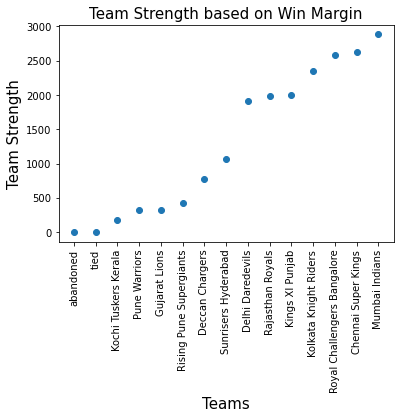

In [25]:
myList = sorted_d.items()
x, y = zip(*myList) 

plt.scatter(x, y)
plt.xticks(rotation = 90)
plt.xlabel('Teams', size = 15); plt.ylabel('Team Strength', size = 15); 
plt.title('Team Strength based on Win Margin', size = 15);
plt.show()

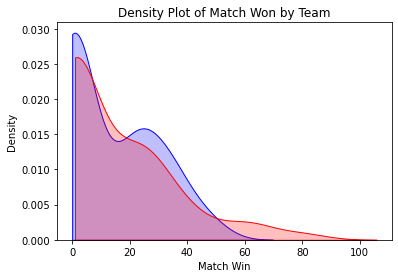

In [26]:
# Match Winner distribution by Team Name

sns.kdeplot(df_like.loc[df_like['match_winner'] == 'Sunrisers Hyderabad', 'total_win_margin_state'], label = 'Sunrisers', color='blue', shade = True, clip=(0.0, 200.0))
sns.kdeplot(df_like.loc[df_like['match_winner'] == 'Mumbai Indians', 'total_win_margin_state'], label = 'Mumbai Indians',color='red', shade = True, clip=(1.0, 200.0))
plt.xlabel('Match Win'); plt.ylabel('Density'); plt.title('Density Plot of Match Won by Team');

### Sunrisers
#### Power Hitters
* David Warner
* Rashid Khan
* Jonny Bairstow

### Mumbai Indians
#### Power Hitters
* Hardik Pandya
* Keiron Pollard
* Dewald Brevis
* Jaydev Unadkat
* Tim David
* Daniel Sams
* Suryakumar Yadav
* Tilak Varma

<br />
<center>
<img src="data/images/making_fun.webp" width=400 />
</center>

In [27]:
win_lose = df_prior

# total_home_wins

win_lose['total_home_wins'] = (win_lose['match_winner'] == win_lose['Team1']).groupby(win_lose['Team1']).transform('sum')

In [28]:
win_lose1 = win_lose[win_lose['match_winner'] == win_lose['Team1']].groupby(['Team1']).size().reset_index(name='count') 

In [29]:
win_lose1 = win_lose1.sort_values(by = ['count'], ascending= [True])
win_lose1

,Team1,count
5,Kochi Tuskers Kerala,3
3,Gujarat Lions,5
8,Pune Warriors,6
10,Rising Pune Supergiants,7
1,Deccan Chargers,13
12,Sunrisers Hyderabad,23
2,Delhi Daredevils,34
4,Kings XI Punjab,35
9,Rajasthan Royals,35
6,Kolkata Knight Riders,41


### Team Strength (Win by number of runs) is directly proportional to Team Wins

<AxesSubplot:xlabel='Team1'>

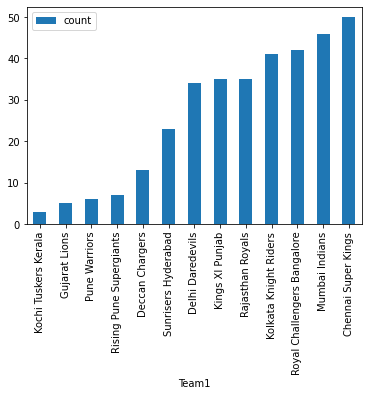

In [30]:
win_lose1.plot(kind='bar',x='Team1',y='count')

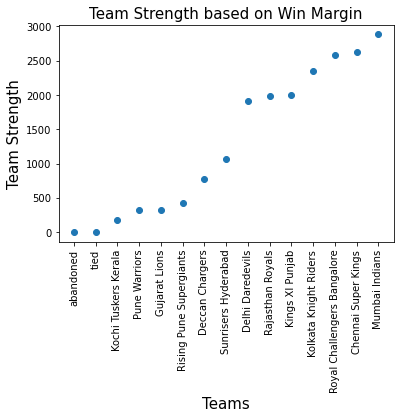

In [31]:
myList = sorted_d.items()
x, y = zip(*myList) 

plt.scatter(x, y)
plt.xticks(rotation = 90)
plt.xlabel('Teams', size = 15); plt.ylabel('Team Strength', size = 15); 
plt.title('Team Strength based on Win Margin', size = 15);
plt.show()

In [32]:
g1 = df_prior.groupby('TeamIndex')
def_prior_final = -np.log(g1['total_win_margin_state'].mean() + g1['total_win_margin_non_state'].mean())
def_prior_final

TeamIndex
0    -3.588219
1    -3.501964
2    -3.466969
3    -3.361050
4    -3.305817
5    -3.497456
6    -3.248186
7    -3.324779
8    -3.555348
9    -3.364293
10   -3.317800
11   -3.358638
12   -3.467966
dtype: float64

So We got our priors!! 

#### For 2017 Mumbai Indians were the Winner of IPL

#### Let's look at how the players stat were for the year for Mumbai Indians

### Mumbai Indians Players 2017



### Let's see the same for Amulya's favourite Team Sunrisers Hyderabad
### Sunrisers Hyderabad Players 2017

## Likelihood

## Formula
Team Strength ~ strike_rate_home + strike_rate_away + total_win_margin_state + total_win_margin_non_state

In [50]:
df_like_bay = df_like[['Team1', 'Team2', 'match_winner', 'Season_Year', 'total_win_margin_state', 'strike_rate_home', 'consistency_home', 'total_win_margin_non_state', 'strike_rate_away', 'consistency_away']]
df_like_bay

,Team1,Team2,match_winner,Season_Year,total_win_margin_state,strike_rate_home,consistency_home,total_win_margin_non_state,strike_rate_away,consistency_away
248,Chennai Super Kings,Mumbai Indians,Mumbai Indians,2012,0.0,22.329167,125.58,40.0,15.722500,87.14
249,Kolkata Knight Riders,Delhi Daredevils,Delhi Daredevils,2012,0.0,21.857692,123.28,40.0,20.838889,100.09
250,Mumbai Indians,Pune Warriors,Pune Warriors,2012,0.0,15.722500,87.14,28.0,15.978333,100.48
251,Rajasthan Royals,Kings XI Punjab,Rajasthan Royals,2012,31.0,22.361429,113.53,0.0,19.662105,127.89
252,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,2012,20.0,18.493750,117.01,0.0,20.838889,100.09
...,...,...,...,...,...,...,...,...,...,...
632,Delhi Daredevils,Royal Challengers Bangalore,Royal Challengers Bangalore,2017,0.0,18.520000,104.24,10.0,14.948235,98.24
633,Mumbai Indians,Rising Pune Supergiants,Rising Pune Supergiants,2017,0.0,22.592667,110.57,20.0,18.220625,109.26
634,Sunrisers Hyderabad,Kolkata Knight Riders,Kolkata Knight Riders,2017,0.0,26.870000,114.66,35.0,21.500667,111.66
635,Mumbai Indians,Kolkata Knight Riders,Mumbai Indians,2017,30.0,22.592667,110.57,0.0,21.500667,111.66


### Formula from Ordinary Least Squares Linear Regression

## Implementing Bayesian Linear Regression

In [51]:
# Formula for Bayesian Linear Regression (follows R formula syntax
formula = 'total_win_margin_state ~ ' + ' + '.join(['%s' % variable for variable in df_like_bay.columns[5:]])
formula

'total_win_margin_state ~ strike_rate_home + consistency_home + total_win_margin_non_state + strike_rate_away + consistency_away'

### Likelihood Prior Distribution using Student T

#### We can perform the above Bayesian Linear Modeling using a Student's T-distribution as the prior for the data likelihood. 
#### as it has has more weight in the tails of the distribution so this makes it more robust to the outliers.

### Traceplot of All Samples

In [52]:
# Below shows the trace with a vertical line at the mean of the trace
def plot_trace(trace):
    # Traceplot with vertical lines at the mean value
    ax = pm.traceplot(trace, figsize=(14, len(trace.varnames)*1.8),
                      lines={k: v['mean'] for k, v in pm.summary(trace).iterrows()})
    
    matplotlib.rcParams['font.size'] = 16
    
    # Labels with the median value
    for i, mn in enumerate(pm.summary(trace)['mean']):
        ax[i, 0].annotate('{:0.2f}'.format(mn), xy = (mn, 0), xycoords = 'data', size = 8,
                          xytext = (-18, 18), textcoords = 'offset points', rotation = 90,
                          va = 'bottom', fontsize = 'large', color = 'red')

### We can perform the Bayesian Linear Modeling using a Student's T-distribution as the prior for the data likelihood. A Student's T Distribution has more weight in the tails of the distribution so it is more robust to outliers.

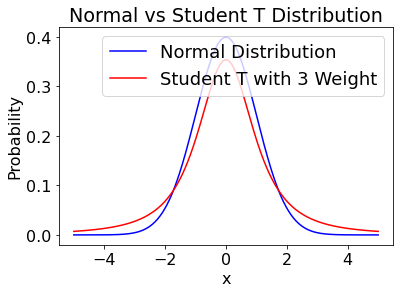

In [53]:
x = np.linspace(-5, 5, num = 500)

# Generate pdf of normal distribution
y_norm = scipy.stats.norm.pdf(x)

# PDF of t-distribution with 2 degrees of freedom
y_t = scipy.stats.t.pdf(x, df = 2)

plt.plot(x, y_norm, 'b-', label = 'Normal Distribution')
plt.plot(x, y_t, 'r-', label = 'Student T with 3 Weight')
plt.legend(prop = {'size': 18}, loc = 1)
plt.xlabel('x'); plt.ylabel('Probability'); plt.title('Normal vs Student T Distribution');

In [54]:
#Context for the model
with pm.Model() as normal_model:
    
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.Normal()
    
    # Creating the model using formula and data
    pm.GLM.from_formula(formula, data = df_like_bay, family = family)
    
    # Perform Markov Chain Monte Carlo sampling
    normal_trace = pm.sample(draws=2000, chains = 2, tune = 500)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
/Users/nidhitiwari/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sd, consistency_away, strike_rate_away, total_win_margin_non_state, consistency_home, strike_rate_home, Intercept]


Sampling 2 chains for 500 tune and 2_000 draw iterations (1_000 + 4_000 draws total) took 30 seconds.


### Building Model using Student T

#### Create Model in PyMC3 and Sample from Posterior
We now build the model using the formula defined above and a **Student T distribution** for the **Data Likelihood**. Then, we let a Markov Chain Monte Carlo algorithm draw samples from the posterior to approximate the posterior for each of the model parameters.

In [55]:
# Context for model
with pm.Model() as t_model:
    # Family is Student's T in this case
    family = pm.glm.families.StudentT(df = 2)
    
    # Formula, data, family
    pm.GLM.from_formula(formula, data = df_like_bay, family = family)
    
    # Sample from the posterior 
    t_trace = pm.sample(draws=2000, tune=500)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
/Users/nidhitiwari/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam, consistency_away, strike_rate_away, total_win_margin_non_state, consistency_home, strike_rate_home, Intercept]


Sampling 4 chains for 500 tune and 2_000 draw iterations (2_000 + 8_000 draws total) took 65 seconds.
The acceptance probability does not match the target. It is 0.8878166545011872, but should be close to 0.8. Try to increase the number of tuning steps.


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/nidhitiwari/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/var/folders/kg/26hhdb_92d7f9tm9bpwqc55r0000gn/T/ipykernel_57380/4188922825.py:4: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  ax = pm.traceplot(trace, figsize=(14, len(trace.varnames)*1.8),
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/nidhitiwari/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future 

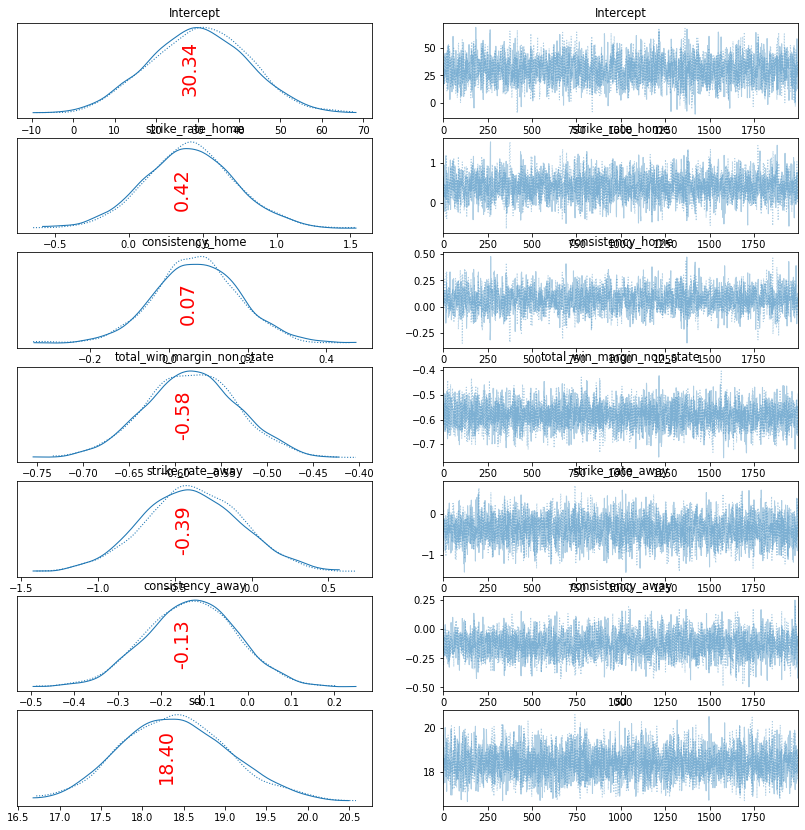

In [56]:
plot_trace(normal_trace);

/var/folders/kg/26hhdb_92d7f9tm9bpwqc55r0000gn/T/ipykernel_57380/1168672415.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(normal_trace)
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/nidhitiwari/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'strike_rate_home'}>,
        <AxesSubplot:title={'center':'strike_rate_home'}>],
       [<AxesSubplot:title={'center':'consistency_home'}>,
        <AxesSubplot:title={'center':'consistency_home'}>],
       [<AxesSubplot:title={'center':'total_win_margin_non_state'}>,
        <AxesSubplot:title={'center':'total_win_margin_non_state'}>],
       [<AxesSubplot:title={'center':'strike_rate_away'}>,
        <AxesSubplot:title={'center':'strike_rate_away'}>],
       [<AxesSubplot:title={'center':'consistency_away'}>,
        <AxesSubplot:title={'center':'consistency_away'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>]], dtype=object)

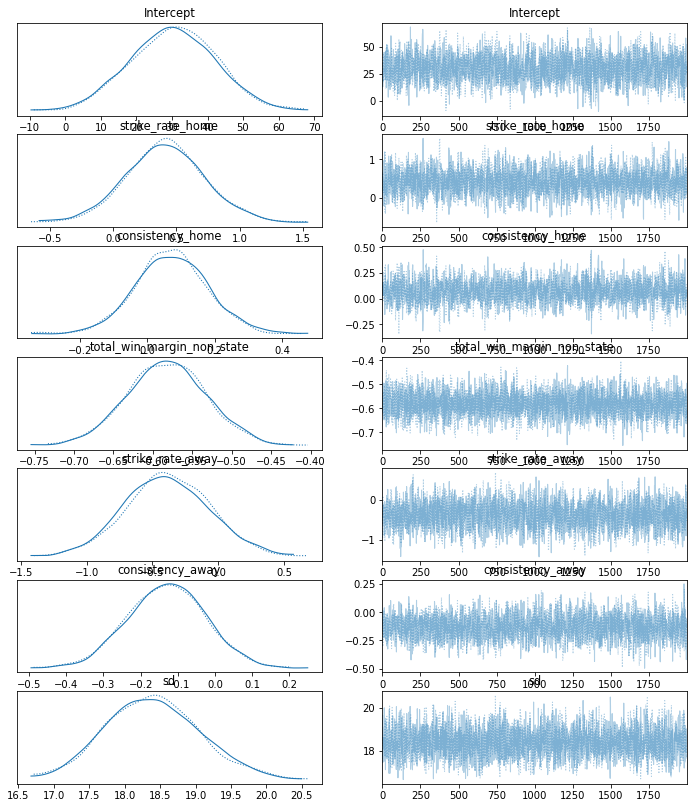

In [57]:
pm.traceplot(normal_trace)

The left side of the traceplot is the marginal posterior: the values for the variable are on the x-axis with the probability for the variable (as determined by sampling) on the y-axis. The different colored lines indicate that we performed two chains of Markov Chain Monte Carlo. From the left side we can see that there is a range of values for each weight.

In [58]:
# pm.forestplot(normal_trace);

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/nidhitiwari/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'strike_rate_home'}>,
        <AxesSubplot:title={'center':'consistency_home'}>],
       [<AxesSubplot:title={'center':'total_win_margin_non_state'}>,
        <AxesSubplot:title={'center':'strike_rate_away'}>,
        <AxesSubplot:title={'center':'consistency_away'}>],
       [<AxesSubplot:title={'center':'sd'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

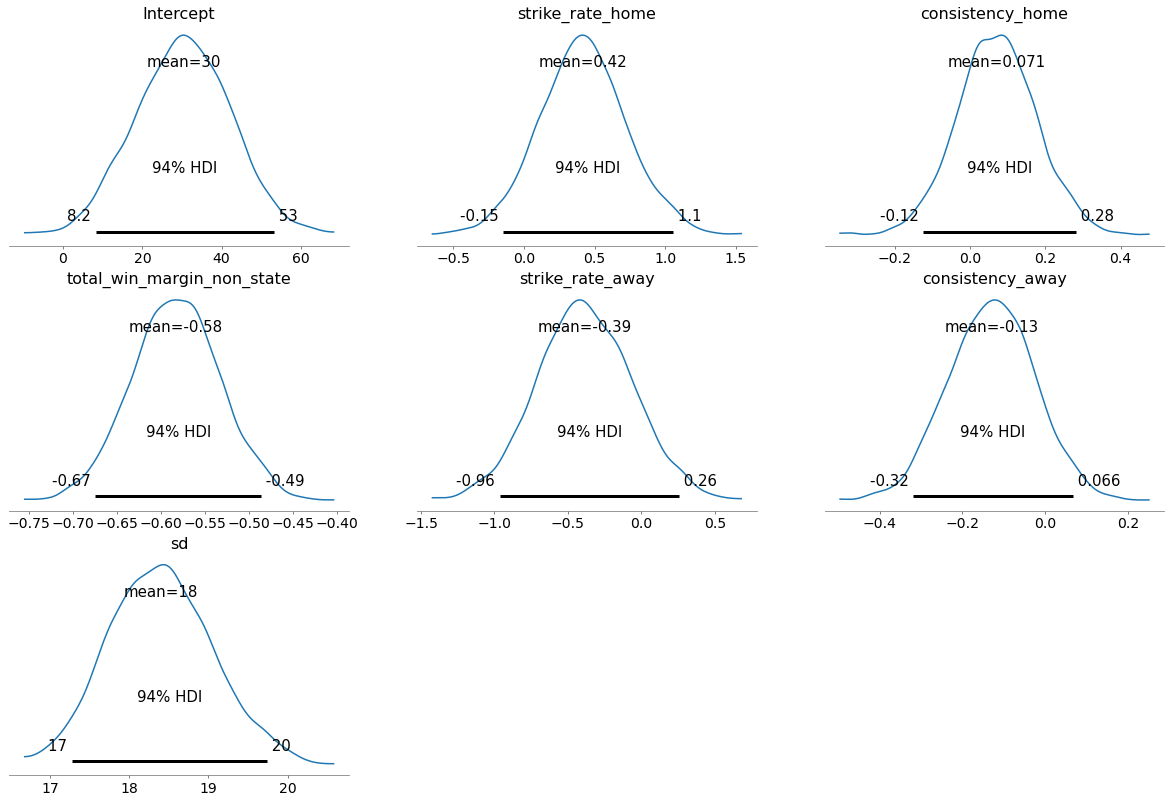

In [59]:
pm.plot_posterior(normal_trace)

Here we can see the mean, which we can use as most likely estimate, and also the entire distribution. 94% HDI stands for the 94% Highest Density Interval and is a credible interval for our parameters. A credible interval is the Bayesian equivalent of a confidence interval in Frequentist statistics. Above we can see a summary of all the model parameters:

In [60]:
# Print out the mean variable weight from the trace
for variable in normal_trace.varnames:
    print('Params: {:15} Model Mean Weight: {:.4f}'.format(variable, np.mean(normal_trace[variable])))

Params: Intercept       Model Mean Weight: 30.3425
Params: strike_rate_home Model Mean Weight: 0.4159
Params: consistency_home Model Mean Weight: 0.0707
Params: total_win_margin_non_state Model Mean Weight: -0.5824
Params: strike_rate_away Model Mean Weight: -0.3857
Params: consistency_away Model Mean Weight: -0.1298
Params: sd_log__        Model Mean Weight: 2.9116
Params: sd              Model Mean Weight: 18.3981


### Interpretations of Mean Weights

#### Based on the sign and location of the weights, we can make the following inferences regarding the features in our dataset:

#### The Win Margin of Team playing opposite is negatively related to the Team Strength of home team
#### Strike Rate of the Team and Consistency is positively related to the Team Strength
#### Strike Rate and Consistency of the opposite Team is negatively related to the Team Strength
#### Strike Rate has more effect on team rather than consistency

In [61]:
pm.summary(normal_trace)


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/nidhitiwari/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,30.342,12.123,8.244,53.079,0.240,0.174,2545.0,2244.0,1.0
strike_rate_home,0.416,0.314,-0.147,1.052,0.006,0.005,2561.0,2315.0,1.0
consistency_home,0.071,0.108,-0.124,0.282,0.002,0.002,2356.0,2388.0,1.0
total_win_margin_non_state,-0.582,0.050,-0.675,-0.485,0.001,0.001,3466.0,2763.0,1.0
strike_rate_away,-0.386,0.323,-0.964,0.258,0.006,0.004,3119.0,2578.0,1.0
consistency_away,-0.130,0.104,-0.319,0.066,0.002,0.002,2708.0,2530.0,1.0
sd,18.398,0.653,17.278,19.745,0.011,0.008,3295.0,2586.0,1.0


In [62]:
df_second_posterir = df_like_bay[['total_win_margin_state', 'strike_rate_home', 'consistency_home', 'total_win_margin_non_state', 'strike_rate_away', 'consistency_away']]

In [63]:
## Increasing Strike Rate
df_second_posterir

,total_win_margin_state,strike_rate_home,consistency_home,total_win_margin_non_state,strike_rate_away,consistency_away
248,0.0,22.329167,125.58,40.0,15.722500,87.14
249,0.0,21.857692,123.28,40.0,20.838889,100.09
250,0.0,15.722500,87.14,28.0,15.978333,100.48
251,31.0,22.361429,113.53,0.0,19.662105,127.89
252,20.0,18.493750,117.01,0.0,20.838889,100.09
...,...,...,...,...,...,...
632,0.0,18.520000,104.24,10.0,14.948235,98.24
633,0.0,22.592667,110.57,20.0,18.220625,109.26
634,0.0,26.870000,114.66,35.0,21.500667,111.66
635,30.0,22.592667,110.57,0.0,21.500667,111.66


### Interpret Variable Effects
#### In order to see the effect of a single variable on the Team Strength, we can change the value of this variable while holding the others constant and look at how the estimated Team Strength change. To do this, we use the plot_posterior_predictive function and assume that all variables except for the one of interest (the one which is changing) are at the median value. We generate a range of values for the changing variable and the function estimates the Team Strength across this range by drawing model parameters from the posterior  distribution.

In [64]:
# Examines the effect of changing a single variable while keeping other variables as constant
# Takes in the name of the variable of interest, the trace, and the data
def model_prediction(var_of_interest, trace, X):
    
    # Variables that do not change
    steady_vars = list(X.columns)
    steady_vars.remove(var_of_interest)
    
    # Linear Model that estimates Team Strength based on the value of the changing variable 
    def lm(value, sample):
        # Prediction is the estimate given a value of the variable of interest
        prediction = sample['Intercept'] + sample[var_of_interest] * value
        
        # Each constant variable is assumed to be at the median value
        for var in steady_vars:
            # Multiply the weight by the median value of the variable
            prediction += sample[var] * X[var].median()
        
        return prediction
    
    
    # Find the minimum and maximum values for the range of the changing variable
    var_min = X[var_of_interest].min()
    var_max = X[var_of_interest].max()
    
    # Plot the estimated Team Strength versus the range of the changing variable
    pm.plot_posterior_predictive_glm(trace, eval=np.linspace(var_min, var_max, 100), 
                                     lm=lm, samples=100, color='blue', 
                                     alpha = 0.4, lw = 2)
    
    # Plot formatting
    plt.xlabel('%s' % var_of_interest, size = 16)
    plt.ylabel('Team Strength', size = 16)
    plt.title("Posterior of Team Stength Vs %s" % var_of_interest , size = 18)
    plt.show()

### Plotting Team Strength Vs Strike Rate

/Users/nidhitiwari/opt/anaconda3/lib/python3.9/site-packages/pymc3/plots/posteriorplot.py:59: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  warnings.warn(


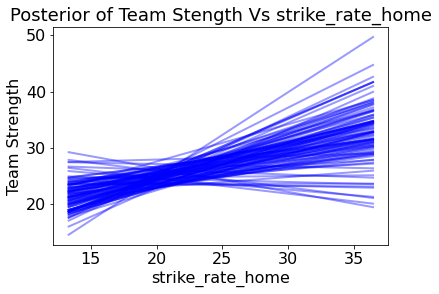

In [66]:
model_prediction('strike_rate_home', normal_trace, df_second_posterir.drop(columns=['total_win_margin_state']))

### The results show the estimated Team Strength versus the range of the query variable for 100 samples from the posterior:

#### Each line (there are 100 in each plot) is drawn by picking one set of model parameters from the posterior trace and evaluating the predicted Team Strength across a range of the query variable. The distribution of the lines shows certainity/uncertainty in the model parameters: the more spread out the lines, the less sure the model is about the effect of that variable. 

#### Since for Strike Rate Graph the distribution of lines is closer, hence Strike Rate is more closely related to Team Strength than consistency

/Users/nidhitiwari/opt/anaconda3/lib/python3.9/site-packages/pymc3/plots/posteriorplot.py:59: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  warnings.warn(


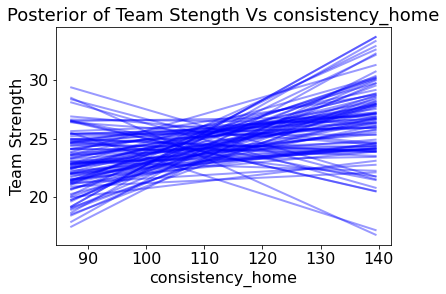

In [68]:
## plot consistency
model_prediction('consistency_home', normal_trace, df_second_posterir.drop(columns=['total_win_margin_state']))

### For Consistency, our model does not look like it's very sure if the effect of increasing the variable makes a difference or not!

## So thats our hypothesis proved !!

<br />
<center>
<img src="data/images/celebration.webp" width=400 />
</center>

### Validating our model and Making Prediction

When it comes to predicting, the Bayesian model can be used to estimate distributions. 

The model for Bayesian Linear Regression is:

<br />
<center>
<img src="data/images/form.png" width=200 />
</center>

Here β is the coefficient matrix or our model parameters, X is the data matrix, and σ is the standard deviation. If we want to make a prediction for a new data point, we can find a normal distribution of estimated outputs by multiplying the model parameters by our data point to find the mean and using the standard deviation from the model parameters.

In this case, we will take the mean of each model parameter from the trace to serve as the best estimate of the parameter. 

### Test Model

#### To Test our Model we have split our data as Training Data and Test Data and Performed predictions based on that

In [69]:
df_like_bay_test = df_like_bay

In [70]:
df_like_bay_test

,Team1,Team2,match_winner,Season_Year,total_win_margin_state,strike_rate_home,consistency_home,total_win_margin_non_state,strike_rate_away,consistency_away
248,Chennai Super Kings,Mumbai Indians,Mumbai Indians,2012,0.0,22.329167,125.58,40.0,15.722500,87.14
249,Kolkata Knight Riders,Delhi Daredevils,Delhi Daredevils,2012,0.0,21.857692,123.28,40.0,20.838889,100.09
250,Mumbai Indians,Pune Warriors,Pune Warriors,2012,0.0,15.722500,87.14,28.0,15.978333,100.48
251,Rajasthan Royals,Kings XI Punjab,Rajasthan Royals,2012,31.0,22.361429,113.53,0.0,19.662105,127.89
252,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,2012,20.0,18.493750,117.01,0.0,20.838889,100.09
...,...,...,...,...,...,...,...,...,...,...
632,Delhi Daredevils,Royal Challengers Bangalore,Royal Challengers Bangalore,2017,0.0,18.520000,104.24,10.0,14.948235,98.24
633,Mumbai Indians,Rising Pune Supergiants,Rising Pune Supergiants,2017,0.0,22.592667,110.57,20.0,18.220625,109.26
634,Sunrisers Hyderabad,Kolkata Knight Riders,Kolkata Knight Riders,2017,0.0,26.870000,114.66,35.0,21.500667,111.66
635,Mumbai Indians,Kolkata Knight Riders,Mumbai Indians,2017,30.0,22.592667,110.57,0.0,21.500667,111.66


#### Splitting our Dataset in Training and Testing

In [88]:
# Takes in our dataframe, finds the most correlated variables related to Team Strength and returns training and testing datasets

def split_data_set(df_like_bay_test):
    # Target is Team Strength or Total Win Margin of a Team
    labels = df_like_bay_test['total_win_margin_state']
    
    # Drop the columns with non numerical values from features
    df_like_bay_test = df_like_bay_test.drop(columns=['Team1', 'Team2', 'match_winner', 'Season_Year' ])
    
    df_like_bay_test = pd.get_dummies(df_like_bay_test)
    
    # Find correlations with the Team Strength
    most_correlated = df_like_bay_test.corr().abs()['total_win_margin_state'].sort_values(ascending=False)
    
    # Maintain the top most correlation features with Team Strength
    most_correlated = most_correlated[:7]
    
    df_like_bay_test = df_like_bay_test.loc[:, most_correlated.index]
#     df_like_bay_test = df_like_bay_test.drop(columns = '')
    
    # Split into training/testing sets with 25% split
    X_train, X_test, y_train, y_test = train_test_split(df_like_bay_test, labels, 
                                                        test_size = 0.25,
                                                        random_state=42)
    
    return X_train, X_test, y_train, y_test

In [89]:
X_train, X_test, y_train, y_test = split_data_set(df_like_bay_test)
X_train.head()

,total_win_margin_state,total_win_margin_non_state,strike_rate_away,strike_rate_home,consistency_away,consistency_home
255,22.0,0.0,19.662105,15.978333,127.89,100.48
267,0.0,35.0,20.838889,15.722500,100.09,87.14
510,9.0,0.0,19.451429,20.708462,123.21,111.60
622,0.0,30.0,21.500667,14.948235,111.66,98.24
586,20.0,0.0,26.870000,22.592667,114.66,110.57


In [90]:
def test_model_ST(model_trace, test_observation):
    
    variable_dict = {}
    for variable in model_trace.varnames:
        variable_dict[variable] = model_trace[variable]

    variable_weights = pd.DataFrame(variable_dict)

    actual_val = test_observation['total_win_margin_state']
    
    # Add in intercept term
    test_observation['Intercept'] = 1
    test_observation = test_observation.drop('total_win_margin_state')
    
    # Align weights and test observation
    variable_weights = variable_weights[test_observation.index]

    # Means for all the weights
    var_means = variable_weights.mean(axis=0)

    # Location of mean for observation
    mean_loc = np.dot(var_means, test_observation)
    
    # Estimates of Toal Win Margin
    estimates = mean_loc + np.random.standard_t(df = 2, size = 1000)

    sns.distplot(estimates, hist = True, kde = True, bins = 19,
                 hist_kws = {'edgecolor': 'k', 'color': 'darkblue'},
                kde_kws = {'linewidth' : 4},
                label = 'Estimated Dist.')
    plt.vlines(x = mean_loc, ymin = 0, ymax = 0.5, 
               linestyles = '-', colors = 'orange',
               label = 'Mean Estimate',
              linewidth = 2.5)
    
    plt.legend(loc = 1)
    plt.title('Density Plot for Test Observation');
    plt.xlabel('total_win_margin_state'); plt.ylabel('Density');
    
    print('True total_win_margin_state = %d' % actual_val)
    print('Average Estimate = %0.4f' % mean_loc)
    print('5%% Estimate = %0.4f    95%% Estimate = %0.4f' % (np.percentile(estimates, 5),
                                       np.percentile(estimates, 95)))

### Make a new prediction from the test set and compare to actual value

In [91]:
def test_model_normal(model_trace, test_observation):
    
    # Observation data
    print('Test Observation:')
    print(test_observation)
    
    variable_dict = {}
    
    for variable in model_trace.varnames:
        variable_dict[variable] = model_trace[variable]

    # Putting results into a dataframe
    variable_weights = pd.DataFrame(variable_dict)
    
    # Standard deviation of the likelihood
    sd_value = variable_weights['sd'].mean()

    actual_val = test_observation['total_win_margin_state']
    
    # Add in intercept term
    test_observation['Intercept'] = 1
    test_observation = test_observation.drop('total_win_margin_state')
    
    # Align weights and test observation
    variable_weights = variable_weights[test_observation.index]

    # Get Means for all the weights
    var_means = variable_weights.mean(axis=0)

    # Location of mean for observation
    mean_loc = np.dot(var_means, test_observation)
    
    # Estimates of total_win_margin_state
    estimates = np.random.normal(loc = mean_loc, scale = sd_value,
                                 size = 1000)

    # Plot all the estimates
    sns.distplot(estimates, hist = True, kde = True, bins = 19,
                 hist_kws = {'edgecolor': 'k', 'color': 'darkblue'},
                kde_kws = {'linewidth' : 4},
                label = 'Estimated Dist.')
    
    # Plot the actual values for the total_win_margin_state
    plt.vlines(x = actual_val, ymin = 0, ymax = 0.1, 
               linestyles = '--', colors = 'orange',
               label = 'True total_win_margin_state',
              linewidth = 2.5)
    
    # Plot the mean estimate
    plt.vlines(x = mean_loc, ymin = 0, ymax = 0.1, 
               linestyles = '-', colors = 'green',
               label = 'Mean Estimate',
              linewidth = 2.5)
    
    plt.legend(loc = 1)
    plt.title('Density Plot for Test Observation');
    plt.xlabel('total_win_margin_state'); plt.ylabel('Density');
    
    # Prediction information
    print('True total_win_margin_state = %d' % actual_val)
    print('Average Estimate = %0.4f' % mean_loc)
    print('5%% Estimate = %0.4f    95%% Estimate = %0.4f' % (np.percentile(estimates, 5),
                                       np.percentile(estimates, 95)))

### Taking the mean of the parameters in the trace, the distribution for a prediction is shown below testing two models Student T and Normal

True total_win_margin_state = 30
Average Estimate = 22.0354
5% Estimate = 19.4092    95% Estimate = 24.9292


/Users/nidhitiwari/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


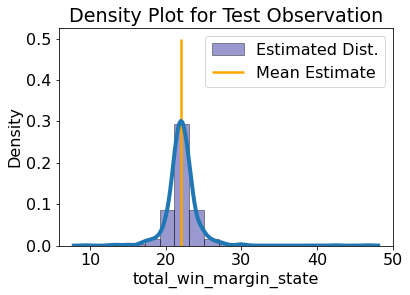

In [92]:
test_model_ST(t_trace, X_test.iloc[60])

Test Observation:
total_win_margin_state         30.0000
total_win_margin_non_state      0.0000
strike_rate_away               17.3625
strike_rate_home               17.2400
consistency_away              100.4300
consistency_home               97.2000
Name: 413, dtype: float64
True total_win_margin_state = 30
Average Estimate = 24.6512
5% Estimate = -6.7692    95% Estimate = 55.3431


/Users/nidhitiwari/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


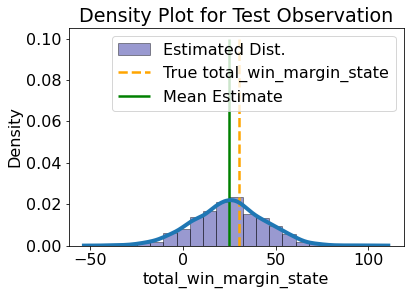

In [93]:
test_model_normal(normal_trace, X_test.iloc[60])

### Here we can see our model is very close to the actual values with Total Team Strength close to the Mean Estimate 

There is some variation between the t-distribution estimates and the normal distribution for the data likelihood.Choosing appropriate priors is very important Bayesian Modeling when using small dataset, but we can get around that by having more data. In the case of limited data but logical priors, Bayesian can be a better method for building models.

### Conclusions
#### In this notebook we used Bayesian Linear Regression to predict IPL Teams performance based on two factors Power Hitting and Consistency. Rather than specifying probabilities for the Bayesian, we did prediction using machine learning. We used Bayesian Linear Regression to create a model mapping the features of the team (strike rate and consistency) to the target (final team strength). The advantages of Bayesian Linear Regression is that if we use logical priors, we can still get a decent estimate with few samples, and the final weights are not a single number, but a distribution of every sample drawn during the simulation. We can then make predictions using all the sampled weights to form a distribution of expected values rather than a single value.

#### Thank You Professor!!
#### Thanks to our TA's for all the help !!

#### Live Long and Prosper!